# Model training walkthrough

machine learning model that categorizes iris flowers by species. 

1. Build a model,
2. Train this model on example data, and
3. Use the model to make predictions about unknown data.

## TensorFlow programming

uses these high-level Swift for TensorFlow concepts:

* Import data with the Datasets API.
* Build models using Swift abstractions.
* Use Python libraries using Swift's Python interoperability when pure Swift libraries are not available.

structured like many TensorFlow programs:

1. Import and parse the data sets.
2. Select the type of model.
3. Train the model.
4. Evaluate the model's effectiveness.
5. Use the trained model to make predictions.

In [0]:
import TensorFlow

import Python
%include "EnableIPythonDisplay.swift"
IPythonDisplay.shell.enable_matplotlib("inline")
let plt = Python.import("matplotlib.pyplot")

In [0]:
// Download a helper file that helps us work around some temporary limitations
// in the dataset API.
import Foundation
import FoundationNetworking
func download(from sourceString: String, to destinationString: String) {
    let source = URL(string: sourceString)!
    let destination = URL(fileURLWithPath: destinationString)
    let data = try! Data.init(contentsOf: source)
    try! data.write(to: destination)
}


In [0]:
download(
    from: "https://raw.githubusercontent.com/tensorflow/swift/master/docs/site/tutorials/TutorialDatasetCSVAPI.swift",
    to: "TutorialDatasetCSVAPI.swift")

## The iris classification problem
* Iris setosa
* Iris virginica
* Iris versicolor

<table>
  <tr><td>
    <img src="https://www.tensorflow.org/images/iris_three_species.jpg"
         alt="Petal geometry compared for three iris species: Iris setosa, Iris virginica, and Iris versicolor">
  </td></tr>
  <tr><td align="center">
    <b>Figure 1.</b> <a href="https://commons.wikimedia.org/w/index.php?curid=170298">Iris setosa</a> (by <a href="https://commons.wikimedia.org/wiki/User:Radomil">Radomil</a>, CC BY-SA 3.0), <a href="https://commons.wikimedia.org/w/index.php?curid=248095">Iris versicolor</a>, (by <a href="https://commons.wikimedia.org/wiki/User:Dlanglois">Dlanglois</a>, CC BY-SA 3.0), and <a href="https://www.flickr.com/photos/33397993@N05/3352169862">Iris virginica</a> (by <a href="https://www.flickr.com/photos/33397993@N05">Frank Mayfield</a>, CC BY-SA 2.0).<br/>&nbsp;
  </td></tr>
</table>


In [0]:
// Import and parse the training dataset

// Download the dataset file and convert it into a structure that can be used by this Swift program.

// from http://download.tensorflow.org/data/iris_training.csv.

let trainDataFilename = "iris_training.csv"
download(from: "http://download.tensorflow.org/data/iris_training.csv", to: trainDataFilename)


In [39]:
// This dataset, `iris_training.csv`, is a plain text file that stores tabular data formatted as comma-separated values (CSV). Let's look a the first 5 entries.
let f = Python.open(trainDataFilename)
for _ in 0..<5 {
    print(Python.next(f).strip())
}
f.close()
// The first line is a header containing information about the dataset:
//   * There are 120 total examples. Each example has four features and one of three possible label names. 

120,4,setosa,versicolor,virginica
6.4,2.8,5.6,2.2,2
5.0,2.3,3.3,1.0,1
4.9,2.5,4.5,1.7,2
4.9,3.1,1.5,0.1,0


None


In [40]:
let featureNames = ["sepal_length", "sepal_width", "petal_length", "petal_width"]
let labelName = "species"
let columnNames = featureNames + [labelName]

print("Features: \(featureNames)")
print("Label: \(labelName)")

Features: ["sepal_length", "sepal_width", "petal_length", "petal_width"]
Label: species


* `0`: Iris setosa
* `1`: Iris versicolor
* `2`: Iris virginica


In [0]:
let classNames = ["Iris setosa", "Iris versicolor", "Iris virginica"]

### Create a Dataset

Swift for TensorFlow's Dataset API is a high-level API for reading data and transforming it into a form used for training.

Eventually, the Dataset API will be able to load data from many file formats. The Dataset API is currently very incomplete, so we include some glue code from "TutorialDatasetCSVAPI.swift" that helps the Dataset API load data from the CSV file into the `IrisBatch` struct.

In [0]:
let batchSize = 32

/// A batch of examples from the iris dataset.
struct IrisBatch {
    /// [batchSize, featureCount] tensor of features.
    let features: Tensor<Float>

    /// [batchSize] tensor of labels.
    let labels: Tensor<Int32>
}

%include "TutorialDatasetCSVAPI.swift"

let trainDataset: Dataset<IrisBatch> = Dataset(
    contentsOfCSVFile: trainDataFilename, hasHeader: true,
    featureColumns: [0, 1, 2, 3], labelColumns: [4]
).batched(batchSize)

The `Dataset<IrisBatch>` is a sequence of `IrisBatch`es. Let's look at the first element of the dataset.

In [43]:
let firstTrainExamples = trainDataset.first!
let firstTrainFeatures = firstTrainExamples.features
let firstTrainLabels = firstTrainExamples.labels
print("First batch of features: \(firstTrainFeatures)")
print("First batch of labels: \(firstTrainLabels)")

First batch of features: [[6.4, 2.8, 5.6, 2.2],
 [5.0, 2.3, 3.3, 1.0],
 [4.9, 2.5, 4.5, 1.7],
 [4.9, 3.1, 1.5, 0.1],
 [5.7, 3.8, 1.7, 0.3],
 [4.4, 3.2, 1.3, 0.2],
 [5.4, 3.4, 1.5, 0.4],
 [6.9, 3.1, 5.1, 2.3],
 [6.7, 3.1, 4.4, 1.4],
 [5.1, 3.7, 1.5, 0.4],
 [5.2, 2.7, 3.9, 1.4],
 [6.9, 3.1, 4.9, 1.5],
 [5.8, 4.0, 1.2, 0.2],
 [5.4, 3.9, 1.7, 0.4],
 [7.7, 3.8, 6.7, 2.2],
 [6.3, 3.3, 4.7, 1.6],
 [6.8, 3.2, 5.9, 2.3],
 [7.6, 3.0, 6.6, 2.1],
 [6.4, 3.2, 5.3, 2.3],
 [5.7, 4.4, 1.5, 0.4],
 [6.7, 3.3, 5.7, 2.1],
 [6.4, 2.8, 5.6, 2.1],
 [5.4, 3.9, 1.3, 0.4],
 [6.1, 2.6, 5.6, 1.4],
 [7.2, 3.0, 5.8, 1.6],
 [5.2, 3.5, 1.5, 0.2],
 [5.8, 2.6, 4.0, 1.2],
 [5.9, 3.0, 5.1, 1.8],
 [5.4, 3.0, 4.5, 1.5],
 [6.7, 3.0, 5.0, 1.7],
 [6.3, 2.3, 4.4, 1.3],
 [5.1, 2.5, 3.0, 1.1]]
First batch of labels: [2, 1, 2, 0, 0, 0, 0, 2, 1, 0, 1, 1, 0, 0, 2, 1, 2, 2, 2, 0, 2, 2, 0, 2, 2, 0, 1, 2, 1, 1, 1, 1]


Notice that the features for the first `batchSize` examples are grouped together (or *batched*) into `firstTrainFeatures`, and that the labels for the first `batchSize` examples are batched into `firstTrainLabels`.

You can start to see some clusters by plotting a few features from the batch, using Python's matplotlib:

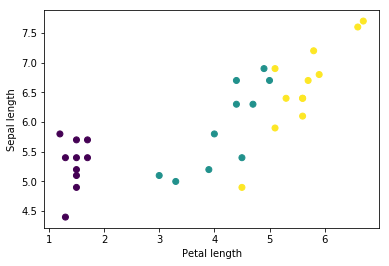

None


In [44]:
let firstTrainFeaturesTransposed = firstTrainFeatures.transposed()
let petalLengths = firstTrainFeaturesTransposed[2].scalars
let sepalLengths = firstTrainFeaturesTransposed[0].scalars

plt.scatter(petalLengths, sepalLengths, c: firstTrainLabels.array.scalars)
plt.xlabel("Petal length")
plt.ylabel("Sepal length")
plt.show()

A model is a `struct` that conforms to [`Layer`](https://www.tensorflow.org/swift/api_docs/Protocols/Layer), defines a [`call(_:)`](https://www.tensorflow.org/swift/api_docs/Protocols/Layer#call_:) method that maps input `Tensor`s to output `Tensor`s. The `call(_:)` method often simply sequences the input through sublayers. 
`IrisModel` sequences the input through three [`Dense`](https://www.tensorflow.org/swift/api_docs/Structs/Dense) sublayers.

In [0]:
let hiddenSize: Int = 20
struct IrisModel: Layer {
    var layer1 = Dense<Float>(inputSize: 4, outputSize: hiddenSize, activation: relu)
    var layer2 = Dense<Float>(inputSize: hiddenSize, outputSize: hiddenSize, activation: relu)
    var layer3 = Dense<Float>(inputSize: hiddenSize, outputSize: 3)
    
    @differentiable
    func callAsFunction(_ input: Tensor<Float>) -> Tensor<Float> {
        return input.sequenced(through: layer1, layer2, layer3)
    }
}

var model = IrisModel()

The activation function determines the output shape of each node in the layer.


In [46]:
// Apply the model to a batch of features.
let firstTrainPredictions = model(firstTrainFeatures)
firstTrainPredictions[0..<5]

[[ -1.7329772, -0.13151097,  0.19777158],
 [ -1.1974344, -0.06770605,   0.1761316],
 [  -1.349941, -0.14748853,  0.13317056],
 [ -1.0228678, 0.017132223,   0.1877974],
 [ -1.1936471, 0.013257623,  0.21275392]]


Here, each example returns a [logit](https://developers.google.com/machine-learning/crash-course/glossary#logits) for each class. 

To convert these logits to a probability for each class, use the [softmax](https://developers.google.com/machine-learning/crash-course/glossary#softmax) function:

In [47]:
model.layer1

▿ Dense<Float>
  - weight : [[  -0.14492011,   -0.37954563,   -0.16574049,     0.3085397,   0.014497697,   -0.28915244,
    0.051759124,    0.20387083,    0.43077147,   -0.37560666,  0.0128573775,    0.14746654,
    -0.46427745,     -0.347071,   -0.27823567,   -0.44490415,    0.21269625,    0.16966563,
     -0.2250281,    0.08960563],
 [    0.4164847,   -0.42250705,    0.37574083,   -0.26941198,    0.12186271,    0.03589827,
   -0.023880959,   -0.20080477,  -0.111144066,   -0.24596316,   -0.44131857,    0.25859576,
   -0.041369915,     0.3730446,     0.3214333,  -0.009039223,   0.106165886,     0.4246788,
    -0.08701587,   -0.38448274],
 [  -0.10086638,   -0.16406566,    0.36039305,    0.40359855,  -0.040762603,   -0.25001335,
     -0.2762763,    -0.3644892,   -0.12599999,   -0.10050154,    -0.3062815,    0.44099373,
     0.32428092,   -0.18351877,  -0.052918136,    0.49296975,  -0.100485384,   -0.18916929,
      0.2956305,   -0.44767243],
 [   0.22463435,    0.27754343,    0.24517715

In [48]:
firstTrainPredictions

[[    -1.7329772,    -0.13151097,     0.19777158],
 [    -1.1974344,    -0.06770605,      0.1761316],
 [     -1.349941,    -0.14748853,     0.13317056],
 [    -1.0228678,    0.017132223,      0.1877974],
 [    -1.1936471,    0.013257623,     0.21275392],
 [    -0.9195043, -0.00034573674,      0.1541571],
 [     -1.129523,    0.028615057,     0.21262708],
 [    -1.7541509,    -0.10661441,     0.23848464],
 [     -1.606487,    -0.08647609,     0.23940669],
 [     -1.071094,  -0.0008304119,      0.1797471],
 [    -1.3189634,    -0.11956555,     0.16512263],
 [     -1.700394,    -0.10663462,     0.23425575],
 [    -1.1852164,    0.047620267,      0.2252725],
 [    -1.1387551,   -0.008177459,     0.18791792],
 [    -2.0848308,    -0.20082211,     0.22726771],
 [    -1.5921623,    -0.14633834,      0.1995019],
 [    -1.8481008,    -0.16160625,      0.2072714],
 [    -2.0289984,    -0.14850974,       0.228187],
 [    -1.7058232,     -0.1600421,     0.19565877],
 [    -1.1867101,   0.000838071

In [49]:
softmax(firstTrainPredictions[0..<5])

[[0.077790916,   0.3858663,   0.5363428],
 [ 0.12431279,  0.38472518,  0.49096212],
 [ 0.11448321,  0.38103098,  0.50448585],
 [ 0.13918012,  0.39377084,  0.46704903],
 [ 0.11870335,  0.39683965,    0.484457]]


Taking the `argmax` across classes gives us the predicted class index. But, the model hasn't been trained yet, so these aren't good predictions.

In [50]:
print("Prediction: \(firstTrainPredictions.argmax(squeezingAxis: 1))")
print("    Labels: \(firstTrainLabels)")

Prediction: [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
    Labels: [2, 1, 2, 0, 0, 0, 0, 2, 1, 0, 1, 1, 0, 0, 2, 1, 2, 2, 2, 0, 2, 2, 0, 2, 2, 0, 1, 2, 1, 1, 1, 1]


 [`softmaxCrossEntropy(logits:labels:)`](https://www.tensorflow.org/swift/api_docs/Functions#/s:10TensorFlow19softmaxCrossEntropy6logits6labelsAA0A0VyxGAG_AFys5Int32VGtAA0aB13FloatingPointRzlF) function which takes the model's class probability predictions and the desired label, and returns the average loss across the examples.

In [51]:
TensorFlow.softmaxCrossEntropy

: ignored

In [52]:
let untrainedLogits = model(firstTrainFeatures)
let untrainedLoss = softmaxCrossEntropy(logits: untrainedLogits, labels: firstTrainLabels)
print("Loss test: \(untrainedLoss)")

Loss test: 1.169491


### Create an optimizer

An *[optimizer](https://developers.google.com/machine-learning/crash-course/glossary#optimizer)* applies the computed gradients to the model's variables to minimize the `loss` function. You can think of the loss function as a curved surface (see Figure 3) and we want to find its lowest point by walking around. The gradients point in the direction of steepest ascent—so we'll travel the opposite way and move down the hill. By iteratively calculating the loss and gradient for each batch, we'll adjust the model during training. Gradually, the model will find the best combination of weights and bias to minimize loss. And the lower the loss, the better the model's predictions.

<table>
  <tr><td>
    <img src="https://cs231n.github.io/assets/nn3/opt1.gif" width="70%"
         alt="Optimization algorithms visualized over time in 3D space.">
  </td></tr>
  <tr><td align="center">
    <b>Figure 3.</b> Optimization algorithms visualized over time in 3D space.<br/>(Source: <a href="http://cs231n.github.io/neural-networks-3/">Stanford class CS231n</a>, MIT License, Image credit: <a href="https://twitter.com/alecrad">Alec Radford</a>)
  </td></tr>
</table>

Swift for TensorFlow has many [optimization algorithms](https://github.com/rxwei/DeepLearning/blob/master/Sources/DeepLearning/Optimizer.swift) available for training. This model uses the SGD optimizer that implements the *[stochastic gradient descent](https://developers.google.com/machine-learning/crash-course/glossary#gradient_descent)* (SGD) algorithm. The `learningRate` sets the step size to take for each iteration down the hill. This is a *hyperparameter* that you'll commonly adjust to achieve better results.

In [0]:
let optimizer = SGD(for: model, learningRate: 0.01)

Differentiate the loss with respect to the model's parameters

In [54]:
let (loss, grads) = model.valueWithGradient { model -> Tensor<Float> in
    let logits = model(firstTrainFeatures)
    return softmaxCrossEntropy(logits: logits, labels: firstTrainLabels)
}
print("Current loss: \(loss)")

Current loss: 1.169491


Next, we pass the gradient that we just calculated to the optimizer, which updates the model's differentiable variables accordingly:

In [0]:
optimizer.update(&model.allDifferentiableVariables, along: grads)

If we calculate the loss again, it should be smaller, because gradient descent steps (usually) decrease the loss:

In [56]:
let logitsAfterOneStep = model(firstTrainFeatures)
let lossAfterOneStep = softmaxCrossEntropy(logits: logitsAfterOneStep, labels: firstTrainLabels)
print("Next loss: \(lossAfterOneStep)")

Next loss: 1.1405698


### Training loop



In [0]:
let epochCount = 500
var trainAccuracyResults: [Float] = []
var trainLossResults: [Float] = []

In [58]:
func accuracy(predictions: Tensor<Int32>, truths: Tensor<Int32>) -> Float {
    return Tensor<Float>(predictions .== truths).mean().scalarized()
}

for epoch in 1...epochCount {
    var epochLoss: Float = 0
    var epochAccuracy: Float = 0
    var batchCount: Int = 0
    for batch in trainDataset {
        let (loss, grad) = model.valueWithGradient { (model: IrisModel) -> Tensor<Float> in
            let logits = model(batch.features)
            return softmaxCrossEntropy(logits: logits, labels: batch.labels)
        }
        optimizer.update(&model.allDifferentiableVariables, along: grad)
        
        let logits = model(batch.features)
        epochAccuracy += accuracy(predictions: logits.argmax(squeezingAxis: 1), truths: batch.labels)
        epochLoss += loss.scalarized()
        batchCount += 1
    }
    epochAccuracy /= Float(batchCount)
    epochLoss /= Float(batchCount)
    trainAccuracyResults.append(epochAccuracy)
    trainLossResults.append(epochLoss)
    if epoch % 50 == 0 {
        print("Epoch \(epoch): Loss: \(epochLoss), Accuracy: \(epochAccuracy)")
    }
}

Epoch 50: Loss: 0.5034555, Accuracy: 0.6979167
Epoch 100: Loss: 0.36751425, Accuracy: 0.9114583
Epoch 150: Loss: 0.26342344, Accuracy: 0.984375
Epoch 200: Loss: 0.19525252, Accuracy: 0.984375
Epoch 250: Loss: 0.1575833, Accuracy: 0.984375
Epoch 300: Loss: 0.13529453, Accuracy: 0.984375
Epoch 350: Loss: 0.12082361, Accuracy: 0.984375
Epoch 400: Loss: 0.110710636, Accuracy: 0.9921875
Epoch 450: Loss: 0.103334695, Accuracy: 0.9921875
Epoch 500: Loss: 0.09789996, Accuracy: 0.9921875


see the *loss* go down and the *accuracy* go up.

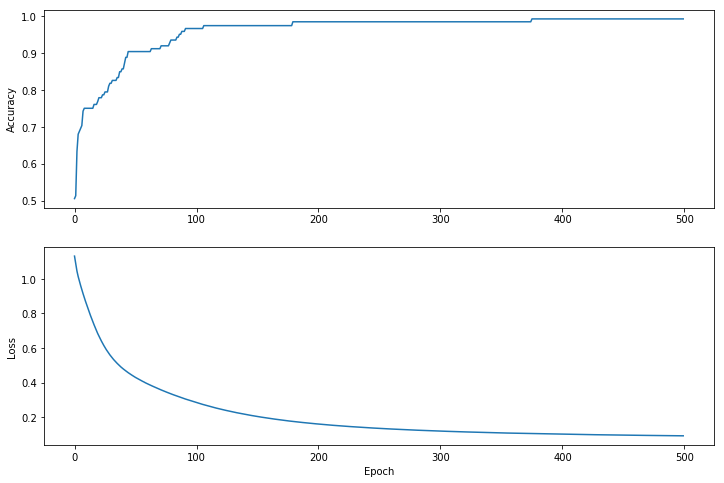

None


In [31]:
plt.figure(figsize: [12, 8])

let accuracyAxes = plt.subplot(2, 1, 1)
accuracyAxes.set_ylabel("Accuracy")
accuracyAxes.plot(trainAccuracyResults)

let lossAxes = plt.subplot(2, 1, 2)
lossAxes.set_ylabel("Loss")
lossAxes.set_xlabel("Epoch")
lossAxes.plot(trainLossResults)

plt.show()

Note that the y-axes of the graphs are not zero-based.

### Setup the test dataset
http://download.tensorflow.org/data/iris_training.csv:

In [0]:
let testDataFilename = "iris_test.csv"
download(from: "http://download.tensorflow.org/data/iris_test.csv", to: testDataFilename)

 Now load it into a `Dataset`:

In [0]:
let testDataset: Dataset<IrisBatch> = Dataset(
    contentsOfCSVFile: testDataFilename, hasHeader: true,
    featureColumns: [0, 1, 2, 3], labelColumns: [4]
).batched(batchSize)

### Evaluate the model on the test dataset

In [34]:
// NOTE: With `batchSize = 32` and 30 examples in the test dataset, only one batch will run in the loop.
for testBatch in testDataset {
    let logits = model(testBatch.features)
    let predictions = logits.argmax(squeezingAxis: 1)
    print("Test batch accuracy: \(accuracy(predictions: predictions, truths: testBatch.labels))")
}

Test batch accuracy: 0.96666664


We can see on the first batch, for example, the model is usually correct:

In [35]:
let firstTestBatch = testDataset.first!
let firstTestBatchLogits = model(firstTestBatch.features)
let firstTestBatchPredictions = firstTestBatchLogits.argmax(squeezingAxis: 1)

print(firstTestBatchPredictions)
print(firstTestBatch.labels)

[1, 2, 0, 1, 1, 1, 0, 1, 1, 2, 2, 0, 2, 1, 1, 0, 1, 0, 0, 2, 0, 1, 2, 1, 1, 1, 0, 1, 2, 1]
[1, 2, 0, 1, 1, 1, 0, 2, 1, 2, 2, 0, 2, 1, 1, 0, 1, 0, 0, 2, 0, 1, 2, 1, 1, 1, 0, 1, 2, 1]


### Could be better if use train, val, test set; current method confuse people

## Use the trained model to make predictions

* `0`: Iris setosa
* `1`: Iris versicolor
* `2`: Iris virginica

In [36]:
let unlabeledDataset: Tensor<Float> =
    [[5.1, 3.3, 1.7, 0.5],
     [5.9, 3.0, 4.2, 1.5],
     [6.9, 3.1, 5.4, 2.1]]

let unlabeledDatasetPredictions = model(unlabeledDataset)

for i in 0..<unlabeledDatasetPredictions.shape[0] {
    let logits = unlabeledDatasetPredictions[i]
    let classIdx = logits.argmax().scalar!
    print("Example \(i) prediction: \(classNames[Int(classIdx)]) (\(softmax(logits)))")
}

Example 0 prediction: Iris setosa ([   0.9941551,  0.005844921, 9.754981e-11])
Example 1 prediction: Iris versicolor ([0.0014089192,    0.9922127, 0.0063782893])
Example 2 prediction: Iris virginica ([3.2954597e-06,      0.203958,     0.7960387])
